In [1]:
import sys
sys.path.append("/Users/markdalterio/PycharmProjects/Quantitative-Finance-Toolbox")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import inv
import os
from Bonds.zero_coupon import ZeroCoupon
from Rates.forward import Forward
from Options.call_put import EuropeanCall
from Replication.two_state import *
import warnings
warnings.filterwarnings('ignore')

### The Two State World ###

To begin we consider a two state world where an underlying can either increase to $S1$ or $S2$ at time $T$. We also consider a risk-free (non-volatile) annually compounded interest rate between $t=0$ and $t=1$

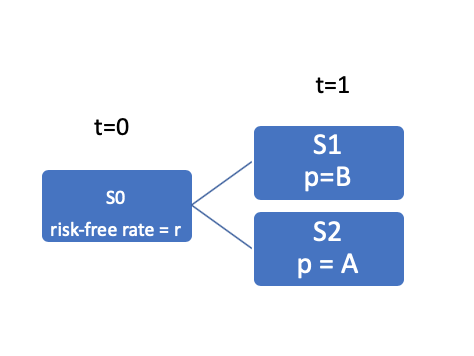

Note that we do not know the probabilities that result in these prices. From this world we will derive the probabilities $A$ and $B$ under which there is no opportunity of arbitrage.

In [3]:
# Price of underlying at t=0
S0 = 100

# Price of underlying at t=1 with probability B
S1 = 120

# Price of underlying at t = 1 with probability A
S2 = 90

# The risk free rate between 0 and T
r = 0.1

# Two state world so binomial tree with 1 step / maturity 1
T = 1

### Replication Portfolio ###

We consider a replication portfolio with $\lambda$ units of the underlying $S_0$ at $t=0$ and $\mu$ ZC Bonds. Remember that the pay-off of a ZC Bond at maturity is 1:


$ZC(t=T, T) = \frac{1}{(1+r)^{T-T}}$

$         = 1$

The pay off of this portfolio would be:

$ P = S_T\times \lambda + \mu \times ZC(T,T)$

In [4]:
def replication_payoff(st, lam, mu, r):
    
    zc = ZeroCoupon(1, r).calculate_value(1)
    
    return st*lam + mu * zc

### Solving the Linear System of Replication Portfolios for States A and B ###

Note that the pay-off of the portfolio is the same as investing in a Call option where the is the foward price of the underlying.

$K = S_0 \times e^{r(T-t)}$

$K = S_0 \times {(1+r)^{T-t}}$


$C(T,T) = S_T\times \lambda + \mu \times ZC(T,T) = P$

However, since there are two possible states there are two possible pay-offs with probabilities A and B. For no opportunity of arbitrage to exist, $P$ must be constant in all possible (both) states of the world at $T$. In mathematical terms, this means there is a solution to the linear set of equations:

$S1\times \lambda + \mu \times ZC(T,T) = max(0, S_T(1) - K)$

$S2\times \lambda + \mu \times ZC(T,T) = max(0, S_T(2) - K)$

Solving these equations for $\lambda$ and $\mu$ will give us the portfolio configuration that replicates an investment in the underlying for all states of the world.

$\begin{matrix}
S1 & 1 \\
S2 & 1
\end{matrix} \times \begin{matrix}
\lambda \\
\mu
\end{matrix}=\begin{matrix}
max(0, S_T(1) - K) \\
max(0, S_T(2) - K)
\end{matrix}$

$\begin{matrix}
\lambda \\
\mu
\end{matrix}=\begin{matrix}
S1 & 1 \\
S2 & 1
\end{matrix}^{-1} \times \begin{matrix}
max(0, S_T(1) - K) \\
max(0, S_T(2) - K)
\end{matrix}$

In [5]:
f = Forward(1, 0.1)

K = f.calculate_payoff(100, 0)

print(K)

def solve_two_state_system(st1, st2, K):

    #Pay of of calls in states 1 and 2
    c1 = EuropeanCall(K)
    c2 = EuropeanCall(K)
    c1p = c1.payoff('Long', st1)
    c2p = c2.payoff('Long', st2)

    #inverse of the matrix containing inforamation on the value of the underlying and ZC bonds at maturity.
    A = np.array([[st1, 1], [st2, 1]])
    A_inv = np.linalg.inv(A)

    #Array containing the values of the Call Options at maturity with Strike K
    b = np.array([[c1p], [c2p]])

    #Finding the values of lambda and mu which satisfy both equations
    solution = np.dot(A_inv, b)

    results = dict()
    results["Lambda"] = solution[0]
    results["Mu"] = solution[1]

    return results

# S1 -> value of underlying in state A, S2 -> value of underlying in state B, K -> foward price of the underlying
solution = solve_two_state_system(S1, S2, K)

print(solution)

lam = solution['Lambda']
mu = solution['Mu']

110.00000000000001
{'Lambda': array([ 0.33333333]), 'Mu': array([-30.])}


### Evaluation of the replication portfolio at T ###

The equation for the replication portfolio at T is:

$S_T \times \lambda + \mu \times ZC(T,T) = max(0, S_T - K)$

We now want to evaluate the fair price of the call option given the two state world with probabilities A and B.

$S_0 \times \lambda + \mu \times ZC(0, T) = C(0, T)$

It is important to note that we have just found the portfolio which provides the same pay-off in both states of the word at $t=1$ and therefore provides the fair price of the Call Option.

When we say the fair price of the call option we are referring to the expected pay-off at maturity without including fees. 



In [6]:
C_fairprice = S0 * lam + mu * ZeroCoupon(1, r).calculate_value(0)

print("C(0,T) = {}".format(C_fairprice))

C(0,T) = [ 6.06060606]


### Risk Neutral Probabilities ###

The probability of the underlying increasing to S1 and resulting in pay-off C1, A, is referred to as p. Since there are only two states the probability of decreasing to state B, where the pay-off of the call is 0, is 1-p.

The expected value of the call option at $t=0$ is the discounted value of the expected pay-off at maturity. 

$E_0[C(T,T)] = \frac{1}{(1+r)^1} \times [p \times max(0, S1-K) + (1-p) \times max(S2-K)]$

This can be solved for the risk neutral probability $p*$ which corresponds to the case where the expected pay-off of the Call Option is risk neutral - i.e. it is the same despite being in state A or B.

$p* = \frac{(1+r)^1 \times E_0[C(T,T)]-C2}{C1-C2}$

This is significant because these result from risk neutral pricing through replication of the Call option. Therefore the probabilities of the pay off being state A or B apply to the underlying increasing to state A and B as well.


In [7]:
p = ((1+r)**1 * C_fairprice - 0)/(10-0)

print("The risk-neutral probabiliy of increasing to state A: {}".format(p))
print("The risk-neutral probabiliy of Decreasing to state B: {}".format(1-p))

The risk-neutral probabiliy of increasing to state A: [ 0.66666667]
The risk-neutral probabiliy of Decreasing to state B: [ 0.33333333]


### Expected Value of $S_T$ ###

Since we have the probabilities of the underlying increasing or decreasing, we can find the expected value at $t=T$.

$E[S_T] = p \times S1 + (1-p) \times S2 $

In [8]:
ST = p*S1 + (1-p)*S2

print('The Expected Value of the underlying is {}'.format(ST))

The Expected Value of the underlying is [ 110.]


### $E[S_T]$ is Equal to it's foward value ###

This is an interesting result because $E[S_T]$ is just equal it's own risk-free foward value. This also implied that the expected pay-off of the call option is zero under risk-neutral conditions. The value of $p$ which results in this is referred to as $p*$ since it is risk-neutral.

Prices are discounted expectations of pay-outs under the **risk-neutral probability**.

In [9]:
def multi_dim_data(N):
    
    rs = np.linspace(0, 0.2, N)
    
    s1s = np.linspace(100, 160, N)
    
    M, B = np.meshgrid(rs,s1s)
    
    zs = np.array([call_fair_price(100, s1s, 90, Forward(1, rs).calculate_payoff(100, 0), rs) for rs, s1s in zip(np.ravel(M), np.ravel(B))])
    Z = zs.reshape(M.shape)
    
        
    return M,B,Z,rs,s1s,zs

M,B,Z,rs,s1s,zs = multi_dim_data(100)

In [10]:
def multi_dim_data(N):
    
    rs = np.linspace(0, 0.2, N)
    
    s1s = np.linspace(100, 160, N)
    
    M, B = np.meshgrid(rs,s1s)
    
    zs = np.array([risk_neutral_probability(rs, s1s, 90, Forward(1, rs).calculate_payoff(100, 0), 100) for rs, s1s in zip(np.ravel(M), np.ravel(B))])
    Z = zs.reshape(M.shape)
    
        
    return M,B,Z,rs,s1s,zs

M2,B2,Z2,rs2,s1s2,zs2 = multi_dim_data(100)

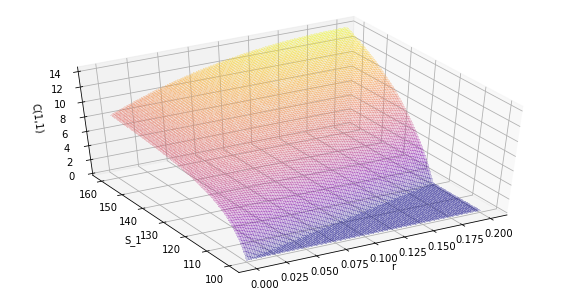

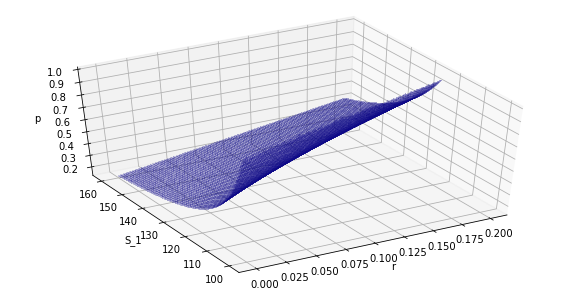

In [11]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(111, projection='3d')


ax1.plot_surface(M, B, Z, rstride=1, cstride=1, alpha=0.2, linewidth=0, antialiased=False,cmap='plasma')

#ax2.plot(M[1,:], Z[:,1])
ax1.view_init(elev=45, azim=-120)
ax1.set_xlabel('r')
ax1.set_ylabel('S_1')
ax1.set_zlabel('C(1,1)')


fig = plt.figure(figsize = (10,5))
ax2 = fig.add_subplot(111, projection='3d')

ax2.plot_surface(M2, B2, Z2, rstride=1, cstride=1, alpha=0.2, linewidth=0, antialiased=False,cmap='plasma')

#ax2.plot(M[1,:], Z[:,1])
ax2.view_init(elev=45, azim=-120)
ax2.set_xlabel('r')
ax2.set_ylabel('S_1')
ax2.set_zlabel('p')



plt.show()
plt.show()

### Risk Neutral Call Price Sensitivity to the risk-free rate and upper price (State A) of the underlying ###

We consider the slope along the r-axis (rate). As the upper price increases (State A) we see that the call-pay off increases how ever is still sensitive to the rate. If the rates increase the expected call pay-off increases because it is more probable. 

As the upper price increases, we see the probability of this price occuring decreases. However, is still sensitive to the rates. If the rates are higher the probability of the price occuring increases.

In the expected call-pay off we see a flat reigon with a positive gradient as r increases. Since an increase in r will result in an increase of the strike, K, it would take longer for the low values of ST1 in S_T1-K to become positive.

These sensitivities make sense and are derived without considering risk, or volatility, in their derivation and we find that 